# <font size="15">Shear Pocket Measurement</font>

<font size="5">Step 1: Merging</font>

In [5]:
import cv2
import numpy as np

def Merging(image1,image2):
    # Ensure both images have the same size
    if image1.shape != image2.shape:
        raise ValueError("The dimensions of the images do not match!")

    # Perform a bitwise OR operation to combine the images
    combined_image = cv2.bitwise_or(image1, image2)
    # Save the combined image
    cv2.imwrite('../Images/combined_image22.png', combined_image)

    # Display the images (optional)

    # cv2.namedWindow('Combined Image', cv2.WINDOW_NORMAL)
    # cv2.imshow('Combined Image', combined_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

<font size="4">Input result from Yolov9 and SAM</font>

In [6]:
image = cv2.imread('/home/d8/Work/yolov9/runs/predict-seg/exp47/masks/55_combined.png', cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread('../Images/P1h.jpg', cv2.IMREAD_GRAYSCALE)
# Change the directory after first time

In [8]:
Merging(image,image1)

ValueError: The dimensions of the images do not match!

<font size="5">Step2: Rotating and Measuring</font>

In [1]:
import cv2
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def shear_pocket_measurement(image, image1, contour_index):
    # Calculate new dimensions for rotated image
    def calculate_new_dimensions(w, h, angle):
        cos = np.abs(np.cos(np.radians(angle)))
        sin = np.abs(np.sin(np.radians(angle)))
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        return nW, nH

    # Rotate image by a given angle
    def rotate_image(image, angle, nW, nH):
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
        return cv2.warpAffine(image, M, (nW, nH))

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the color range you want to segment
    l_b = np.array([0, 0, 138])  # Lower bound
    u_b = np.array([255, 255, 255])  # Upper bound

    # Create a mask using the defined lower and upper bounds
    mask = cv2.inRange(hsv, l_b, u_b)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    rect1 = cv2.minAreaRect(contours[contour_index])
    angle = rect1[-1]
    nW1, nH1 = calculate_new_dimensions(image.shape[1], image.shape[0], angle)
    nW2, nH2 = calculate_new_dimensions(image1.shape[1], image1.shape[0], angle)

    img = rotate_image(image, angle, nW1, nH1)
    img1 = rotate_image(image1, angle, nW2, nH2)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, l_b, u_b)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    if contours and contour_index < len(contours):
        contour = contours[contour_index]

        # Get adjacent white pixels
        def get_adjacent_white_pixels(object_mask):
            adjacent_white_pixels = []
            for y in range(1, object_mask.shape[0] - 1):
                for x in range(1, object_mask.shape[1] - 1):
                    if object_mask[y, x] == 255:
                        if (object_mask[y - 1, x] == 0 or object_mask[y + 1, x] == 0 or
                                object_mask[y, x - 1] == 0 or object_mask[y, x + 1] == 0):
                            adjacent_white_pixels.append((x, y))
            return adjacent_white_pixels

        # Draw lines between randomly selected points in the groups
        def draw_lines_between_groups(img, group1, group2, same_coordinate='x', color=(0, 255, 255)):
            if group1 and group2:
                point1 = random.choice(group1)
                point2 = random.choice(group2)
                if same_coordinate == 'x':
                    point2 = (point1[0], point2[1])
                else:
                    point2 = (point2[0], point1[1])
                cv2.line(img, point1, point2, color, 2)
                length = np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
                return point1, point2, length
            return None, None, None

        object_mask = np.zeros_like(mask)
        cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

        adjacent_white_pixels = get_adjacent_white_pixels(object_mask)

        adjacent_white_pixels_sorted = sorted(adjacent_white_pixels, key=lambda pixel: pixel[1], reverse=True)
        adjacent_white_pixels_sorted_smallest = sorted(adjacent_white_pixels, key=lambda pixel: pixel[1])

        adjacent_white_pixels_sorted_x = sorted(adjacent_white_pixels, key=lambda pixel: pixel[0])
        adjacent_white_pixels_sorted_x_smallest = sorted(adjacent_white_pixels, key=lambda pixel: pixel[0], reverse=True)

        selected_pixels = adjacent_white_pixels_sorted[:300]
        selected_pixels1 = adjacent_white_pixels_sorted_smallest[:300]
        selected_pixels2 = adjacent_white_pixels_sorted_x[:300]
        selected_pixels3 = adjacent_white_pixels_sorted_x_smallest[:300]

        y_counts = defaultdict(list)
        for (x, y) in selected_pixels:
            y_counts[y].append((x, y))

        y_counts1 = defaultdict(list)
        for (x, y) in selected_pixels1:
            y_counts1[y].append((x, y))

        x_counts = defaultdict(list)
        for (x, y) in selected_pixels2:
            x_counts[x].append((x, y))

        x_counts1 = defaultdict(list)
        for (x, y) in selected_pixels3:
            x_counts1[x].append((x, y))

        most_common_y = max(y_counts, key=lambda y: len(y_counts[y]))
        most_common_group = y_counts[most_common_y]

        most_common_y1 = max(y_counts1, key=lambda y: len(y_counts1[y]))
        most_common_group1 = y_counts1[most_common_y1]

        most_common_x = max(list(x_counts.keys()), key=lambda x: len(x_counts[x]))
        most_common_group2 = x_counts[most_common_x]

        most_common_x1 = max(list(x_counts1.keys()), key=lambda x: len(x_counts1[x]))
        most_common_group3 = x_counts1[most_common_x1]

        point1, point2, length = draw_lines_between_groups(img, most_common_group, most_common_group1, same_coordinate='x', color=(0, 0, 255))
        if point1 and point2:
            print(f"Length of the line from {point1} to {point2}: {length:.2f} mm")

        point1, point2, length = draw_lines_between_groups(img, most_common_group2, most_common_group3, same_coordinate='y', color=(0, 255, 0))
        if point1 and point2:
            print(f"Length of the line from {point1} to {point2}: {length:.2f} mm")

        draw_lines_between_groups(img1, most_common_group, most_common_group1, same_coordinate='x', color=(0, 0, 255))
        draw_lines_between_groups(img1, most_common_group2, most_common_group3, same_coordinate='y', color=(0, 255, 0))

        for (x, y) in selected_pixels:
            img[y, x] = [255, 0, 255]

        for (x, y) in selected_pixels1:
            img[y, x] = [255, 0, 255]

    # Convert BGR images to RGB for Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # Display images using Matplotlib
    plt.figure(figsize=(20, 10))  # Adjust the size as needed
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb)
    plt.title('Shear pocket measurement')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img1_rgb)
    plt.title('Shear pocket measurement')
    plt.axis('on')

    plt.show()

In [1]:
import cv2
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def shear_pocket_measurement(image, image1, contour_index):
    # Calculate new dimensions for rotated image
    def calculate_new_dimensions(w, h, angle):
        cos = np.abs(np.cos(np.radians(angle)))
        sin = np.abs(np.sin(np.radians(angle)))
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        return nW, nH

    # Rotate image by a given angle
    def rotate_image(image, angle, nW, nH):
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
        return cv2.warpAffine(image, M, (nW, nH))

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the color range you want to segment
    l_b = np.array([0, 0, 138])  # Lower bound
    u_b = np.array([255, 255, 255])  # Upper bound

    # Create a mask using the defined lower and upper bounds
    mask = cv2.inRange(hsv, l_b, u_b)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    rect1 = cv2.minAreaRect(contours[contour_index])
    angle = rect1[-1]
    nW1, nH1 = calculate_new_dimensions(image.shape[1], image.shape[0], angle)
    nW2, nH2 = calculate_new_dimensions(image1.shape[1], image1.shape[0], angle)

    img = rotate_image(image, angle, nW1, nH1)
    img1 = rotate_image(image1, angle, nW2, nH2)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, l_b, u_b)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    if contours and contour_index < len(contours):
        contour = contours[contour_index]

        # Get adjacent white pixels
        def get_adjacent_white_pixels(object_mask):
            adjacent_white_pixels = []
            for y in range(1, object_mask.shape[0] - 1):
                for x in range(1, object_mask.shape[1] - 1):
                    if object_mask[y, x] == 255:
                        if (object_mask[y - 1, x] == 0 or object_mask[y + 1, x] == 0 or
                                object_mask[y, x - 1] == 0 or object_mask[y, x + 1] == 0):
                            adjacent_white_pixels.append((x, y))
            return adjacent_white_pixels

        # Draw lines between randomly selected points in the groups
        def draw_lines_between_groups(img, group1, group2, same_coordinate='x', color=(0, 255, 255)):
            if group1 and group2:
                point1 = random.choice(group1)
                point2 = random.choice(group2)
                if same_coordinate == 'x':
                    point2 = (point1[0], point2[1])
                else:
                    point2 = (point2[0], point1[1])
                cv2.line(img, point1, point2, color, 2)
                length = np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
                return point1, point2, length
            return None, None, None

        object_mask = np.zeros_like(mask)
        cv2.drawContours(object_mask, [contour], -1, 255, thickness=cv2.FILLED)

        adjacent_white_pixels = get_adjacent_white_pixels(object_mask)

        adjacent_white_pixels_sorted = sorted(adjacent_white_pixels, key=lambda pixel: pixel[1], reverse=True)
        adjacent_white_pixels_sorted_smallest = sorted(adjacent_white_pixels, key=lambda pixel: pixel[1])

        adjacent_white_pixels_sorted_x = sorted(adjacent_white_pixels, key=lambda pixel: pixel[0])
        adjacent_white_pixels_sorted_x_smallest = sorted(adjacent_white_pixels, key=lambda pixel: pixel[0], reverse=True)

        selected_pixels = adjacent_white_pixels_sorted[:300]
        selected_pixels1 = adjacent_white_pixels_sorted_smallest[:300]
        selected_pixels2 = adjacent_white_pixels_sorted_x[:300]
        selected_pixels3 = adjacent_white_pixels_sorted_x_smallest[:300]

        y_counts = defaultdict(list)
        for (x, y) in selected_pixels:
            y_counts[y].append((x, y))

        y_counts1 = defaultdict(list)
        for (x, y) in selected_pixels1:
            y_counts1[y].append((x, y))

        x_counts = defaultdict(list)
        for (x, y) in selected_pixels2:
            x_counts[x].append((x, y))

        x_counts1 = defaultdict(list)
        for (x, y) in selected_pixels3:
            x_counts1[x].append((x, y))

        most_common_y = max(y_counts, key=lambda y: len(y_counts[y]))
        # print(most_common_y)
        most_common_group = y_counts[most_common_y]
        # print( most_common_group)

        most_common_y1 = max(y_counts1, key=lambda y: len(y_counts1[y]))
        most_common_group1 = y_counts1[most_common_y1]

        most_common_x = max(list(x_counts.keys()), key=lambda x: len(x_counts[x]))
        most_common_group2 = x_counts[most_common_x]

        most_common_x1 = max(list(x_counts1.keys()), key=lambda x: len(x_counts1[x]))
        most_common_group3 = x_counts1[most_common_x1]
        
        # Coordinates of points A, B, C, and D
        A = (most_common_group2[0][0], most_common_group[0][1])
        B = (most_common_group3[0][0], most_common_group[0][1])
        C = (most_common_group2[0][0], most_common_group1[0][1])
        D = (most_common_group3[0][0], most_common_group1[0][1])

        # Print the points
        # print("Point A:", A)
        # print("Point B:", B)
        # print("Point C:", C)
        # print("Point D:", D)

        # Draw circles at each of these points
        cv2.circle(img1, A, 5, (0, 0, 255), -1)  # Point A in red
        cv2.circle(img, B, 5, (0, 255, 0), -1)  # Point B in green
        cv2.circle(img, C, 5, (255, 0, 0), -1)  # Point C in blue
        cv2.circle(img, D, 5, (255, 255, 0), -1)  # Point D in yellow

        # Optionally, add text labels for the points
        font = cv2.FONT_HERSHEY_SIMPLEX
        # cv2.putText(img1, 'A', A, font, 1, (0, 0, 255), 2, cv2.LINE_AA)
        # cv2.putText(img1, 'B', B, font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # cv2.putText(img1, 'C', C, font, 1, (255, 0, 0), 2, cv2.LINE_AA)
        # cv2.putText(img1, 'D', D, font, 1, (255, 255, 0), 2, cv2.LINE_AA)

        # Draw lines with different colors to form a rectangle
        cv2.line(img1, A, B, (255, 0, 0), 2)  # Line from A to B (blue)
        cv2.line(img1, B, D, (0, 255, 0), 2)  # Line from B to D (green)
        cv2.line(img1, D, C, (0, 0, 255), 2)  # Line from D to C (red)
        cv2.line(img1, C, A, (255, 255, 0), 2)  # Line from C to A (yellow)

        # Convert BGR to RGB for displaying with Matplotlib
        img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        # Display the image with Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.title('Shear Pocket Measurement with Rectangle')
        plt.axis('on')
        plt.show()

       
        # Draw lines between selected points
        point1, point2, length = draw_lines_between_groups(img, most_common_group, most_common_group1, same_coordinate='x', color=(0, 0, 255))
        if point1 and point2:
            print(f"Length of the line from {point1} to {point2}: {length:.2f} mm")

        point1, point2, length = draw_lines_between_groups(img, most_common_group2, most_common_group3, same_coordinate='y', color=(0, 255, 0))
        if point1 and point2:
            print(f"Length of the line from {point1} to {point2}: {length:.2f} mm")

#         draw_lines_between_groups(img1, most_common_group, most_common_group1, same_coordinate='x', color=(0, 0, 255))
#         draw_lines_between_groups(img1, most_common_group2, most_common_group3, same_coordinate='y', color=(0, 255, 0))

#         # Highlight the selected pixels
#         for (x, y) in selected_pixels:
#             img[y, x] = [255, 0, 255]

#         for (x, y) in selected_pixels1:
#             img[y, x] = [255, 0, 255]

#     # Convert BGR images to RGB for Matplotlib
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

#     # Display images using Matplotlib
#     plt.figure(figsize=(20, 10))  # Adjust the size as needed
#     plt.subplot(1, 2, 1)
#     plt.imshow(img_rgb)
#     plt.title('Shear pocket measurement')
#     plt.axis('on')

#     plt.subplot(1, 2, 2)
#     plt.imshow(img1_rgb)
#     plt.title('Shear pocket measurement')
#     plt.axis('on')

#     plt.show()


In [12]:
# image = cv2.imread("/home/d8/Work/Segment-Anything-Jyp/merged.png")
image = cv2.imread("/home/d8/Work/Segment-Anything-Jyp/6merged.png")

image1 = cv2.imread("/home/d8/Work/Master_Project/Images/Emseoung/2/66.jpg") #Binary Image

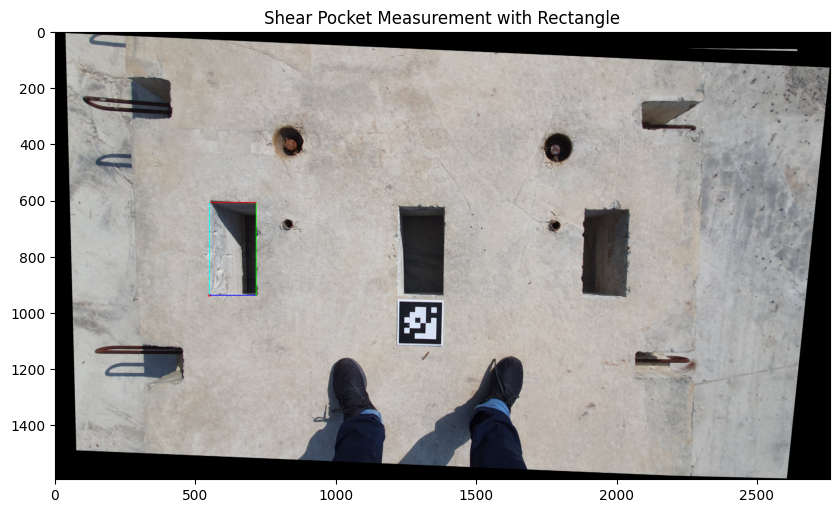

Length of the line from (571, 939) to (571, 609): 330.00 mm
Length of the line from (550, 891) to (716, 891): 166.00 mm


In [13]:
shear_pocket_measurement(image, image1, contour_index=0)

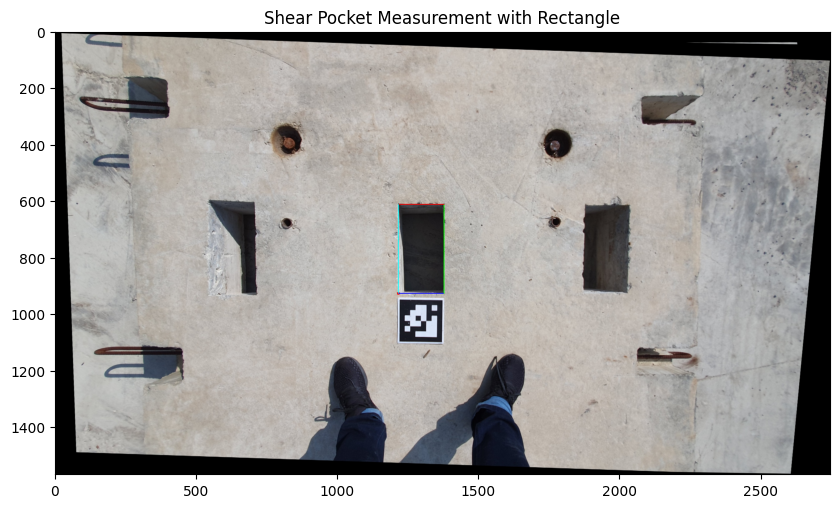

Length of the line from (1301, 928) to (1301, 613): 315.00 mm
Length of the line from (1216, 883) to (1378, 883): 162.00 mm


In [14]:
shear_pocket_measurement(image, image1, contour_index=1)

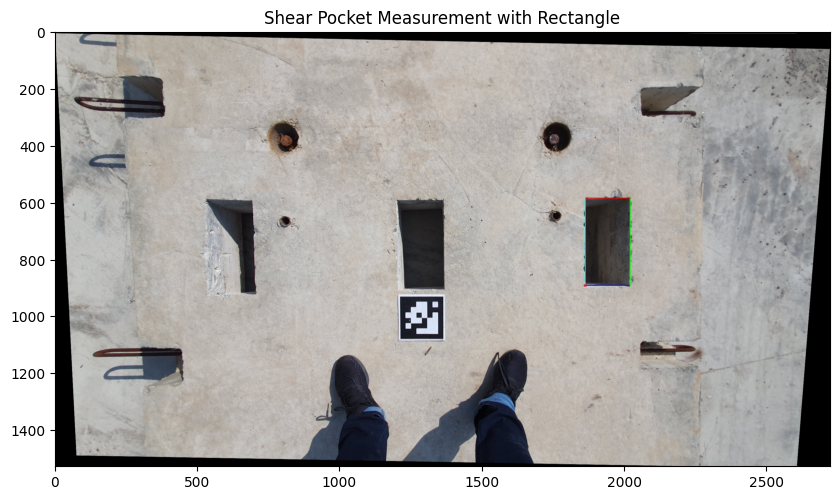

Length of the line from (1967, 892) to (1967, 586): 306.00 mm
Length of the line from (1863, 852) to (2021, 852): 158.00 mm


In [15]:
shear_pocket_measurement(image, image1, contour_index=2)